In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt


In [2]:
col_list = ["text"]
df_all=pd.read_csv("Merged140620to200620.csv")
df = pd.read_csv("Merged140620to200620.csv", usecols = col_list)


In [3]:
# to see full column content instead of truncated text
pd.set_option('display.max_colwidth', -1)

In [4]:
#install tweet preprocessor package to remove URLs, hashtags, mentions
#!pip install tweet-preprocessor

import preprocessor as p



In [6]:
import re
import nltk
import gensim
#from nltk.tokenize import TweetTokenizer
#tt = TweetTokenizer()


from gensim.parsing.porter import PorterStemmer
st = PorterStemmer()



In [7]:
stop_list = nltk.corpus.stopwords.words('english')
#to add on to stop_list - used nltk cuz stop list is in a list. 

#stop_list += ['']

In [8]:
all_tweets1=[]
all_tweets2=[]
all_tweets3=[]
all_tweets4=[] #for sentiment analysis: no stemming and stopwords
all_tweets5=[] # remove stopwords
all_tweets6=[] #lemmitised instead of stemming.. seems better

lemmatizer = nltk.stem.WordNetLemmatizer()

for row in df["text"]:
    
    # remove all urls,mentions, hashtags using twitter preprocessing p
    tweets1 = p.clean(row)
    all_tweets1.append(tweets1)

    #remove digits,punctuations
   
    tweets2=re.sub(r"\b\d+\b","",tweets1)
    all_tweets2.append(tweets2)
    
    
    #tokenise 
    tweets3=list(gensim.utils.tokenize(tweets2))
    all_tweets3.append(tweets3)
    
    #convert to lower case

    tweets4 = [word.lower() for word in tweets3]
    all_tweets4.append(tweets4)
    
    
    #remove stopwords
    tweets5= [word for word in tweets4 if word not in stop_list]
    all_tweets5.append(tweets5)
    
    
    #lemmitise
    tweets6 = [lemmatizer.lemmatize(word) for word in tweets5]
    all_tweets6.append(tweets6)
 

In [9]:
#Code to covert docs to vec
def docs2vecs(docs, dictionary):
    vecs1 = [dictionary.doc2bow(doc) for doc in docs]
    return vecs1


### LDA Gensim Model


In [10]:
#Latent Dirichlet Allocation with Gensim
tweet_dictionary = gensim.corpora.Dictionary(all_tweets6)
tweet_vecs = docs2vecs(all_tweets6, tweet_dictionary)

tweet_lda = gensim.models.ldamodel.LdaModel(corpus=tweet_vecs, id2word=tweet_dictionary, num_topics=10)

In [11]:
topics = tweet_lda.show_topics(10, 15)

for i in range(0, 10):
    print(topics[i])

(0, '0.027*"day" + 0.021*"work" + 0.019*"office" + 0.011*"home" + 0.009*"today" + 0.009*"working" + 0.008*"look" + 0.007*"weekend" + 0.007*"morning" + 0.007*"week" + 0.006*"set" + 0.006*"need" + 0.006*"good" + 0.006*"get" + 0.006*"life"')
(1, '0.027*"get" + 0.014*"sleep" + 0.011*"hustle" + 0.010*"free" + 0.010*"edition" + 0.010*"optimize" + 0.010*"income" + 0.008*"big" + 0.007*"never" + 0.007*"would" + 0.007*"like" + 0.006*"people" + 0.006*"team" + 0.006*"work" + 0.006*"passive"')
(2, '0.013*"amp" + 0.011*"work" + 0.010*"new" + 0.010*"home" + 0.009*"remote" + 0.009*"day" + 0.009*"make" + 0.008*"team" + 0.007*"back" + 0.007*"working" + 0.006*"job" + 0.006*"office" + 0.006*"read" + 0.005*"going" + 0.005*"really"')
(3, '0.029*"new" + 0.019*"job" + 0.017*"remote" + 0.015*"amp" + 0.011*"u" + 0.010*"work" + 0.006*"learn" + 0.006*"want" + 0.005*"sign" + 0.005*"team" + 0.005*"share" + 0.005*"normal" + 0.005*"home" + 0.005*"webinar" + 0.005*"engineer"')
(4, '0.032*"home" + 0.027*"work" + 0.026*

In [12]:
#this will take a while to run - can skip if you want to test out other results
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
visual= pyLDAvis.gensim.prepare(tweet_lda, tweet_vecs, tweet_dictionary)
pyLDAvis.save_html(visual, "topic_viz.html")

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [13]:
#Code to save the document topic probabilities (theta)

mixture = [dict(tweet_lda[x]) for x in tweet_vecs]
pd.DataFrame(mixture).to_csv("doc_topic_mixture.csv")

In [14]:
# Code to save top 10 words for each topic (beta)
top_words_per_topic = []
for t in range(tweet_lda.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in tweet_lda.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")


### LDA Mallet Model


In [15]:
import gensim
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})

no_topics=10 #make this 2 to test.
no_iter=1000 #make this 50 to test

mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tweet_vecs, iterations=no_iter, num_topics=no_topics, id2word=tweet_dictionary)


D:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
# Show Topics
#print(ldamallet.show_topics(formatted=False))
#print(ldamallet.show_topics())

vecTop= ldamallet.show_topics()
for i in range(0, 10):
    print(vecTop[i])

(0, '0.240*"home" + 0.147*"working" + 0.119*"work" + 0.050*"tip" + 0.027*"stay" + 0.025*"productive" + 0.022*"worker" + 0.020*"remotely" + 0.010*"safe" + 0.008*"hard"')
(1, '0.085*"amp" + 0.065*"team" + 0.043*"learn" + 0.033*"video" + 0.025*"meeting" + 0.025*"virtual" + 0.018*"top" + 0.017*"tool" + 0.013*"set" + 0.012*"give"')
(2, '0.079*"day" + 0.031*"week" + 0.017*"love" + 0.016*"call" + 0.016*"morning" + 0.015*"today" + 0.015*"zoom" + 0.014*"happy" + 0.013*"long" + 0.012*"im"')
(3, '0.077*"business" + 0.076*"make" + 0.054*"free" + 0.046*"online" + 0.042*"today" + 0.034*"money" + 0.033*"start" + 0.030*"check" + 0.016*"earn" + 0.016*"marketing"')
(4, '0.084*"remote" + 0.049*"employee" + 0.021*"productivity" + 0.018*"solution" + 0.016*"data" + 0.015*"challenge" + 0.013*"environment" + 0.012*"security" + 0.012*"workforce" + 0.012*"continue"')
(5, '0.048*"job" + 0.040*"people" + 0.027*"join" + 0.022*"experience" + 0.020*"year" + 0.018*"live" + 0.016*"full" + 0.016*"part" + 0.014*"making"

In [17]:
#this will take a while to run - can skip if you want to test out other results
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
visual= pyLDAvis.gensim.prepare(model, tweet_vecs, tweet_dictionary)
pyLDAvis.save_html(visual, "topic_viz_mallet.html")

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
#Code to save the document topic probabilities (theta)

mixture = [dict(ldamallet[x]) for x in tweet_vecs]
pd.DataFrame(mixture).to_csv("doc_mallet_topic.csv")

In [18]:
# Code to save top 10 words for each topic (beta)
top_words_per_topic = []
for t in range(ldamallet.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamallet.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_mallet_words.csv")

In [19]:
# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=all_tweets6, dictionary=tweet_dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score LDAMallet: ', coherence_ldamallet)

coherence_model_lda = CoherenceModel(model=tweet_lda, texts=all_tweets6, dictionary=tweet_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAModel: ', coherence_lda)


Coherence Score LDAMallet:  0.31987359651131186

Coherence Score LDAModel:  0.28514224051112574


In [20]:
# Choose any k value you desire - might take a while to run
# current kmax is chosen to be 10
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 10, 2):
    #tweet_lda_x = gensim.models.ldamodel.LdaModel(corpus=tweet_vecs, id2word=tweet_dictionary, num_topics=num_topics)
    tweet_lda_x = gensim.models.wrappers.LdaMallet(mallet_path, iterations=100, corpus=tweet_vecs, num_topics=no_topics, id2word=tweet_dictionary)
    coherencemodel = CoherenceModel(model=tweet_lda_x, texts=all_tweets6, dictionary=tweet_dictionary, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(tweet_lda_x)
    coherence_values.append(coherencemodel.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherencemodel.get_coherence()))

print(datetime.datetime.now())

2020-07-14 02:07:27.400023


D:\Anaconda\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#Topics: 2 Score: 0.2855213132223914
#Topics: 4 Score: 0.2935407718413774
#Topics: 6 Score: 0.2737831683331041
#Topics: 8 Score: 0.2817716431808483
2020-07-14 02:08:50.746922


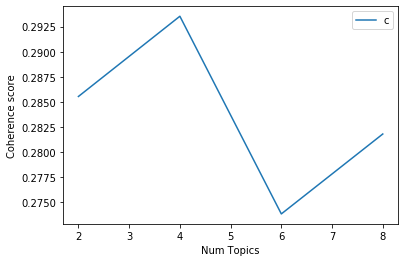

In [21]:
# Show graph

import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2855
Num Topics = 4  has Coherence Value of 0.2935
Num Topics = 6  has Coherence Value of 0.2738
Num Topics = 8  has Coherence Value of 0.2818


In [23]:
#Find most dominant topic
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#I choose model_list[1] where the number of topics is 4

#df_topic_sents_keywords = format_topics_sentences(ldamodel=model_list[1], corpus=tweet_vecs, data=all_tweets6)
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=tweet_vecs, data=all_tweets6)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1228,"job, people, join, experience, year, live, full, part, making, webinar","[real, money, making, monster, pre, launch, visit]"
1,1,5.0,0.1607,"job, people, join, experience, year, live, full, part, making, webinar","[join, hiring, representative, throughout, state, learn, apply]"
2,2,3.0,0.1930,"business, make, free, online, today, money, start, check, earn, marketing","[earn, cash, back, signing, freedom, credit, card]"
3,3,9.0,0.3077,"office, gt, back, thing, work, find, space, visit, offer, check","[nice, recently, launched, trial, version, next, generation, automation, studio, destination, crm, offer, detail, new, version, gt, gt]"
4,4,1.0,0.1303,"amp, team, learn, video, meeting, virtual, top, tool, set, give","[unemployment, benefit, available, want, self, employed, dear, wahfaq, got, laid, friend, told]"
5,5,4.0,0.1525,"remote, employee, productivity, solution, data, challenge, environment, security, workforce, continue","[cyber, security, best, practice, guide, work, home, teleworking, informative, article]"
6,6,2.0,0.1154,"day, week, love, call, morning, today, zoom, happy, long, im","[good, morning]"
7,7,5.0,0.1569,"job, people, join, experience, year, live, full, part, making, webinar","[transcribing, part, one, interview, dog, barking, uncontrollably, delivery, person, try, continue, interview, wrangle, attempt, legit, guard, dog, really, he, giant, golden, fluff]"
8,8,9.0,0.1293,"office, gt, back, thing, work, find, space, visit, offer, check","[family, tired, work, station, work]"
9,9,9.0,0.1409,"office, gt, back, thing, work, find, space, visit, offer, check","[get, medical, billing, amp, coding, job, home]"


In [24]:
#Save a model to disk, or reload a pre-trained model
tweet_lda_sav=ldamallet #Or you can save the best model, model_list[1]

tweet_lda_sav.save("tweet_lda_mallet")

lda_disk=gensim.models.wrappers.LdaMallet.load("tweet_lda_mallet")

### LDA with sklearn

In [35]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
tweet_docs_joined = [" ".join(x) for x in all_tweets6]  #joined to fit vectorizer

In [37]:
# CountVectorizer converts the text documents to a matrix of token counts
vectorizer = CountVectorizer()
sk_tweet_vecs = vectorizer.fit_transform(tweet_docs_joined)

# get_feature_names saves all the words. This allows us to see the words in each topic later
feature_names = vectorizer.get_feature_names()

In [39]:
# Build LDA Model
sk_tweet_lda = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      learning_method='online',   
                                      n_jobs = -1)              # use all available CPU
lda_output = sk_tweet_lda.fit_transform(sk_tweet_vecs)

In [40]:
# write a function to display the 10 topics and for each topic we choose the top most frequent words. 
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 15
display_topics(sk_tweet_lda, feature_names, 15)

Topic 0:
get work remote job new people learn home look company like remotely may want tool
Topic 1:
day work let hour meeting data june happy company click manager place plan client make
Topic 2:
one call still going office amp looking success thing month idea like kid try meeting
Topic 3:
time business gt start make today read free experience new virtual good help team need
Topic 4:
today life way via work day amp would love part join live network daily best
Topic 5:
make back online money time free earn marketing webinar website income internet together little week
Topic 6:
thing much week go never sale must hard bos connection else someone summer power child
Topic 7:
work home new working office employee normal wfh covid change remote long security please business
Topic 8:
home working tip help stay team video productive keep via best could feel zoom remote
Topic 9:
office home know many work check working need link morning future right desk way well


In [55]:
#Set up the environment to display the graphical outputs - will take a while to run
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
# Generate the visuals
visual = pyLDAvis.sklearn.prepare(sk_tweet_lda, sk_tweet_vecs, vectorizer, mds='tsne')
#Save the output|to the html file
pyLDAvis.save_html(visual, "topic_viz_sklearn.html")

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


#### Code for perplexity score

###### Apparently get_topics method is not supported to calculate coherance score for sk learn model and perplexity is normally considered to be the metric to check it's performance

In [56]:
# Compute Perplexity - Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", sk_tweet_lda.perplexity(sk_tweet_vecs))

Perplexity:  2862.5743271199226


In [44]:
# Can take a long time to run. Very values of Kmax for better results
# current kmax is chosen to be 14 - reduce it to run faster
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 14, 2):
    sk_tweet_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = -1)
    sk_tweet_lda_x.fit_transform(sk_tweet_vecs)
    model_topics.append(num_topics)
    model_list.append(sk_tweet_lda_x)
    perplexity_values.append(sk_tweet_lda_x.perplexity(sk_tweet_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(sk_tweet_lda_x.perplexity(sk_tweet_vecs)))

print(datetime.datetime.now())

2020-07-09 13:20:02.721924
#Topics: 2, Score: 2549.6846224438514
#Topics: 4, Score: 2862.5743271199226
#Topics: 6, Score: 3262.3180092990615
#Topics: 8, Score: 3474.123673562861
#Topics: 10, Score: 3687.608091015961
#Topics: 12, Score: 3841.4868390442634
2020-07-09 14:50:11.707094


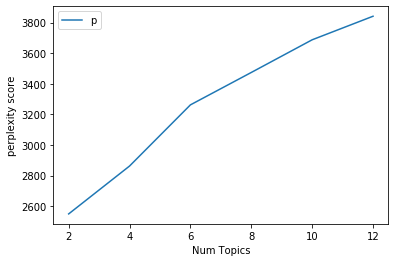

In [45]:
# Show graph

import matplotlib.pyplot as plt

limit=14; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

####  Identify Most Dominant Topic for each Document

In [50]:
# Create Document - Topic Matrix
lda_output = model_list[2].transform(sk_tweet_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(model_list[2].n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(all_tweets6))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
num_doc_to_show = 10  # change this to display the number of documents shown below
df_document_topics = df_document_topic.head(num_doc_to_show).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.71959,0.05556,0.05715,0.05556,0.05558,0.05657,0
Doc1,0.11395,0.01401,0.01394,0.18668,0.01416,0.65725,5
Doc2,0.04167,0.04167,0.04167,0.29167,0.04235,0.54098,5
Doc3,0.04167,0.04167,0.04167,0.79167,0.04167,0.04167,3
Doc4,0.01046,0.01042,0.9478,0.01042,0.01042,0.01049,2
Doc5,0.01283,0.01282,0.12873,0.01283,0.60023,0.23255,4
Doc6,0.00935,0.18909,0.00929,0.71828,0.00927,0.06473,3
Doc7,0.02083,0.02083,0.89583,0.02083,0.02083,0.02083,2
Doc8,0.01857,0.90687,0.01875,0.01858,0.01861,0.01862,1
Doc9,0.02778,0.02778,0.02781,0.02797,0.86088,0.02778,4


In [51]:
import joblib
#Save a model to disk, or reload a pre-trained model

sk_tweet_lda=model_list[1]
joblib.dump(sk_tweet_lda, 'tweet_lda.jl')

# # then reload it with
lda_disk = joblib.load('tweet_lda.jl')

In [52]:
#Code to save theta
import pandas as pd

df_document_topic.to_csv("doc_sk_topic.csv")

In [54]:
# Write code here to save top 10 words for each topic (beta)
top_words_per_topic = []
    
for topic_idx, topic in enumerate(sk_tweet_lda.components_):
    topic_word_P = [(topic_idx, feature_names[i], topic[i]) for i in topic.argsort()[:-no_top_words - 1:-1]]
    top_words_per_topic.extend(topic_word_P)

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_sk_words.csv")